In [28]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [29]:
g = 9.81
l = 1

h = 0.001

# Usado para las graficas
dot = '\u0307'

E = np.array([1, 3, 5, 10, 15])

d_angle = 0.001

phi = np.pi/16
psi = np.pi/16

phi_init = np.array([phi, phi + d_angle, phi + 2*d_angle, phi + 3*d_angle, phi + 4*d_angle])
psi_init = np.array([psi, psi + d_angle, psi + 2*d_angle, psi + 3*d_angle, psi + 4*d_angle])

n_interation = int(10e4)

In [30]:
@jit(nopython = True)
def polar_to_cart (phi):
    x = np.zeros((2, len(phi)))
    for i in range(len(phi)):
        x[0, i] = l * np.cos(phi[i]-np.pi/2)
        x[1, i] = l * np.sin(phi[i]-np.pi/2)
    return x

@jit(nopython = True)
def momento_to_velocidad (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([vec[0], vec[1], phi_dot, psi_dot])

@jit(nopython = True)
def function (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    pphi_dot = 2*np.sin(vec[1]-vec[0])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - 2*g*np.sin(vec[0])
    ppsi_dot = 2*np.sin(vec[0]-vec[1])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - g*np.sin(vec[1]) 
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([phi_dot, psi_dot, pphi_dot, ppsi_dot])

@jit(nopython = True)
def Runge_Kutta (vec_angulos, h):
    k_1 = h*function(vec_angulos)
    k_2 = h*function(vec_angulos + k_1/2)
    k_3 = h*function(vec_angulos + k_2/2)
    k_4 = h*function(vec_angulos + k_3)
    return vec_angulos + (k_1 + k_2 + k_3 + k_4)/6

@jit(nopython = True)
def run_code(n, j, k):
    vec_Cohete_total = np.zeros((int(n_interation), 4))

    phi_dot_init = np.sqrt(E[n] - 2*g*(1-np.cos(phi_init[j]))- g*(1-np.cos(psi_init[k])))
    ppsi_init = phi_dot_init*(np.cos(psi_init[k]-phi_init[j]))**2
    pphi_init = 2*phi_dot_init

    vec_Cohete_total[0] = np.array([phi_init[j], psi_init[k], pphi_init, ppsi_init])
    t = 0
    for i in range(n_interation-1):
        vec_Cohete_total[i+1] = Runge_Kutta(vec_Cohete_total[i], h)
        t = t+ h
    return vec_Cohete_total 


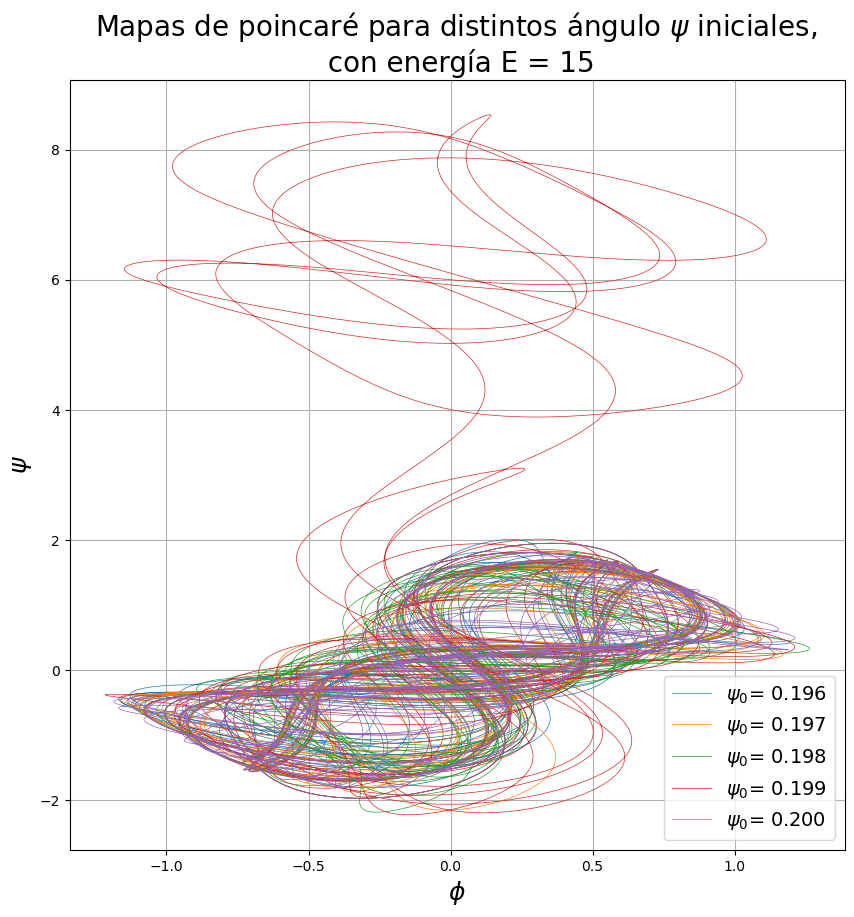

In [34]:
vec_pendulo = np.zeros((len(psi_init), int(n_interation), 4))
k = 4
for i in range(len(psi_init)):
    vec_pendulo[i] = run_code(k, 0, i)

fig=plt.figure(figsize=(10, 10)) #Size of the plot
ax=fig.add_subplot(111)
for i in range(len(psi_init)):
    plt.plot(vec_pendulo[i][:, 0], vec_pendulo[i][:, 1], label=fr"$\psi_0$= {psi_init[i]:.3f}", lw = 0.5)
plt.xlabel(r"$\phi$", fontsize=18)
plt.ylabel(r"$\psi$", fontsize=18)
plt.legend(fontsize = 14)
plt.title(f"Mapas de poincaré para distintos ángulo $\psi$ iniciales, \n con energía E = {E[k]}", fontsize=20)
plt.grid()

plt.savefig(f"latex/plots/poincare_estabilidad_E_{E[k]}.png" , bbox_inches='tight', pad_inches=0.1)